#Recommendation System using SVD

Installing the Surprise. Its a Python scikit for building and analyzing recommender systems that deal with explicit rating data.

In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8MB 324kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617547 sha256=31bc26289f8e9cb0cb54379b6cd4eaa847e5521952c88ec5586be74827c1fee4
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
import numpy as np
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from collections import defaultdict

In [3]:
anime_df = pd.read_csv('/content/drive/My Drive/AnimeList.csv')
review_df = pd.read_csv('/content/drive/My Drive/UserAnimeList.csv')

In [5]:
anime_df.shape

(14478, 31)

In [6]:
review_df.shape

(1048575, 11)

In [7]:
anime_df.head()

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,False,"Aug 16, 2002 to May 23, 2003","{'from': '2002-08-16', 'to': '2003-05-23'}",16 min. per ep.,PG-13 - Teens 13 or older,8.21,36501,307.0,916,93312,3344,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,False,"Oct 6, 2012 to Mar 30, 2013","{'from': '2012-10-06', 'to': '2013-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,8.67,107767,50.0,426,182765,2082,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."


review_df contains only those reviews where the user is currently watching the anime or has completed watching the anime

In [8]:
review_df.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,1362307973,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,1362923691,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,1367081015,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,1362308037,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,1364399953,NaN


Merging both dataframes on the basis of anime_id

In [9]:
df = pd.merge(review_df, anime_df, on="anime_id", suffixes=('_review','_anime'))
df.head()

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,1362307973,NaN,One Piece,One Piece,ONE PIECE,OP,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,True,"Oct 20, 1999 to ?","{'from': '1999-10-20', 'to': None}",24 min.,PG-13 - Teens 13 or older,8.54,423868,91.0,35,720133,69760,Several anime-original arcs have been adapted ...,Fall 1999,Sundays at 09:30 (JST),"{'Adaptation': [{'mal_id': 13, 'type': 'manga'...","Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,"Action, Adventure, Comedy, Super Power, Drama,...","['#01: ""We Are! (ウィーアー!)"" by Hiroshi Kitadani ...","['#01: ""memories"" by Maki Otsuki (eps 1-30)', ..."
1,RedvelvetDaisuki,21,0,0000-00-00,0000-00-00,0,3,0.0,0,1355480701,NaN,One Piece,One Piece,ONE PIECE,OP,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,True,"Oct 20, 1999 to ?","{'from': '1999-10-20', 'to': None}",24 min.,PG-13 - Teens 13 or older,8.54,423868,91.0,35,720133,69760,Several anime-original arcs have been adapted ...,Fall 1999,Sundays at 09:30 (JST),"{'Adaptation': [{'mal_id': 13, 'type': 'manga'...","Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,"Action, Adventure, Comedy, Super Power, Drama,...","['#01: ""We Are! (ウィーアー!)"" by Hiroshi Kitadani ...","['#01: ""memories"" by Maki Otsuki (eps 1-30)', ..."
2,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,1254296345,NaN,One Piece,One Piece,ONE PIECE,OP,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,True,"Oct 20, 1999 to ?","{'from': '1999-10-20', 'to': None}",24 min.,PG-13 - Teens 13 or older,8.54,423868,91.0,35,720133,69760,Several anime-original arcs have been adapted ...,Fall 1999,Sundays at 09:30 (JST),"{'Adaptation': [{'mal_id': 13, 'type': 'manga'...","Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,"Action, Adventure, Comedy, Super Power, Drama,...","['#01: ""We Are! (ウィーアー!)"" by Hiroshi Kitadani ...","['#01: ""memories"" by Maki Otsuki (eps 1-30)', ..."
3,bskai,21,75,0000-00-00,0000-00-00,8,1,0.0,0,1276637483,NaN,One Piece,One Piece,ONE PIECE,OP,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,True,"Oct 20, 1999 to ?","{'from': '1999-10-20', 'to': None}",24 min.,PG-13 - Teens 13 or older,8.54,423868,91.0,35,720133,69760,Several anime-original arcs have been adapted ...,Fall 1999,Sundays at 09:30 (JST),"{'Adaptation': [{'mal_id': 13, 'type': 'manga'...","Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,"Action, Adventure, Comedy, Super Power, Drama,...","['#01: ""We Are! (ウィーアー!)"" by Hiroshi Kitadani ...","['#01: ""memories"" by Maki Otsuki (eps 1-30)', ..."
4,shuzzable,21,579,0000-00-00,0000-00-00,10,1,0.0,0,1391921419,NaN,One Piece,One Piece,ONE PIECE,OP,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,0,Currently Airing,True,"Oct 20, 1999 to ?","{'from': '1999-10-20', 'to': None}",24 min.,PG-13 - Teens 13 or older,8.54,423868,91.0,35,720133,69760,Several anime-original arcs have been adapted ...,Fall 1999,Sundays at 09:30 (JST),"{'Adaptation': [{'mal_id': 13, 'type': 'manga'...","Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,"Action, Adventure, Comedy, Super Power, Drama,...","['#01: ""We Are! (ウィーアー!)"" by Hiroshi Kitadani ...","['#01: ""memories"" by Maki Otsuki (eps 1-30)', ..."


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 41 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   username             1048575 non-null  object 
 1   anime_id             1048575 non-null  int64  
 2   my_watched_episodes  1048575 non-null  int64  
 3   my_start_date        1048575 non-null  object 
 4   my_finish_date       1048575 non-null  object 
 5   my_score             1048575 non-null  int64  
 6   my_status            1048575 non-null  int64  
 7   my_rewatching        828664 non-null   float64
 8   my_rewatching_ep     1048575 non-null  int64  
 9   my_last_updated      1048575 non-null  int64  
 10  my_tags              88264 non-null    object 
 11  title                1048575 non-null  object 
 12  title_english        812981 non-null   object 
 13  title_japanese       1048384 non-null  object 
 14  title_synonyms       770683 non-null   object 
 15

In [11]:
df.shape

(1048575, 41)

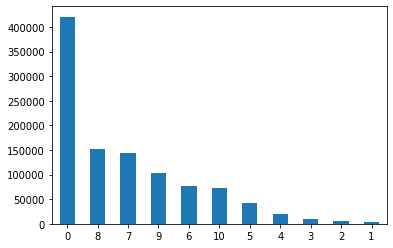

In [12]:
df.my_score.value_counts().sort_values(ascending=False).plot(kind='bar',rot=0)

People have used 0 the most to rate anime. Now, we drop all the unecessary columns before we train the model

In [24]:
df = df.drop(['title_japanese', 'title_synonyms', 'image_url', 'opening_theme', 'rank', 'popularity', 'members', 'rating', 'title_english', 'ending_theme', 'studio', 'licensor', 'producer','related', 'broadcast', 'premiered', 'background', 'favorites','score', 'scored_by', 'duration', 'aired', 'aired_string', 'airing', 'type', 'source', 'episodes','status', 'my_tags', 'my_last_updated', 'my_rewatching_ep', 'my_rewatching', 'my_status', 'my_finish_date', 'my_start_date', 'my_watched_episodes'], axis=1)
df.head()

,username,anime_id,my_score,title,genre
0,karthiga,21,9,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
1,RedvelvetDaisuki,21,0,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
2,Damonashu,21,10,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
3,bskai,21,8,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
4,shuzzable,21,10,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."


In [25]:
df = df.rename(columns={'username': 'uid'})
df.head()

,uid,anime_id,my_score,title,genre
0,karthiga,21,9,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
1,RedvelvetDaisuki,21,0,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
2,Damonashu,21,10,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
3,bskai,21,8,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."
4,shuzzable,21,10,One Piece,"Action, Adventure, Comedy, Super Power, Drama,..."


In [26]:
reader = Reader(rating_scale=(0, 10)) #required to specify the rating range for model to train
data = Dataset.load_from_df(df[['uid', 'anime_id', 'my_score']], reader)

Taking only columns required by the algorithm and splitting the data into training and test sets and training the model for 30 epochs

In [27]:
train, test = train_test_split(data, test_size=0.40)
algo = SVD(verbose=True, n_epochs=30)

In [28]:
algo.fit(train)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


In [29]:
pred = algo.test(test)

In [30]:
accuracy.rmse(pred)

RMSE: 3.5113


3.5113404425927572

We get RMSE of 3.5 which is a little high, but we will still use the model to get top 10 recommendations for users

In [31]:
def get_top_n(predictions, n=10):
   top_n = defaultdict(list)
   for uid, iid, true_r, est, _ in predictions:
      top_n[uid].append((iid, est))

   # Then sort the predictions for each user and retrieve the k highest ones.
   for uid, user_ratings in top_n.items():
      user_ratings.sort(key=lambda x: x[1], reverse=True)
      top_n[uid] = user_ratings[:n]

   return top_n

In [32]:
topn = get_top_n(pred,n=10)

In [33]:
anime_dict = {}
for a_id in df.anime_id.unique():
    anime_dict[a_id] = df.loc[df['anime_id'] == a_id, 'title'].iloc[0]

In [34]:
# to print top 10 recommendations for all the users
# for uid, user_ratings in topn.items():
#     print(uid, [anime_dict[iid] for (iid, _) in user_ratings])

Printing the animes reviewed by a random username and then printing the recommendations for the users for comparison

In [35]:
df[df['uid'] == 'EvaMassacre']

,uid,anime_id,my_score,title,genre
2302,EvaMassacre,59,0,Chobits,"Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen"
3644,EvaMassacre,120,9,Fruits Basket,"Slice of Life, Comedy, Drama, Romance, Fantasy..."
5189,EvaMassacre,232,8,Cardcaptor Sakura,"Adventure, Comedy, Drama, Magic, Romance, Fant..."
6240,EvaMassacre,249,0,InuYasha,"Action, Adventure, Comedy, Historical, Demons,..."
9866,EvaMassacre,853,8,Ouran Koukou Host Club,"Comedy, Harem, Romance, School, Shoujo"
...,...,...,...,...,...
932740,EvaMassacre,33354,0,Cardcaptor Sakura: Clear Card-hen,"Adventure, Comedy, Fantasy, Magic, Romance, Sh..."
936014,EvaMassacre,33743,0,Fuuka,"Drama, Ecchi, Music, Romance, School, Shounen"
946388,EvaMassacre,34839,0,Sanrio Danshi,"Slice of Life, School"
949087,EvaMassacre,35320,9,Cardcaptor Sakura: Clear Card-hen Prologue - S...,"Fantasy, Romance, Shoujo"


In [36]:
for n in topn['EvaMassacre']:
  print(anime_dict[n[0]], df.loc[df['anime_id'] == n[0], 'genre'].iloc[0], sep='|')

Highschool of the Dead|Action, Horror, Supernatural, Ecchi, Shounen
Hataraku Maou-sama!|Comedy, Demons, Supernatural, Romance, Fantasy
Kuragehime|Slice of Life, Comedy, Josei
Sen to Chihiro no Kamikakushi|Adventure, Supernatural, Drama
Sukitte Ii na yo.|Drama, Romance, School, Shoujo
Corpse Party: Missing Footage|Horror, School
Re:Zero kara Hajimeru Isekai Seikatsu|Psychological, Drama, Thriller, Fantasy
Steins;Gate|Thriller, Sci-Fi
Prison School|Comedy, Ecchi, Romance, School, Seinen
Corpse Party: Tortured Souls - Bougyakusareta Tamashii no Jukyou|Mystery, Horror, Supernatural


We can see that the animes recommended belong to the same genres of anime like Comedy, Drama, Sci-Fi, Romance, Adventure that the user has already watched or is watching.